<a href="https://colab.research.google.com/github/MiaMiya/02807-Computational-Tools-for-Data-Science/blob/main/Week4/slides_week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02807 - Computational Tools for Data Science - Week 4

# Today

* At-a-glance visualisations with the **Pandas profiler**
* More Pandas: `apply` and its many uses
* **Static data visualisation** with Pandas and matplotlib
* **Supervised machine learning** for flower classification with **sklearn**
* **Interactive data visualisation** with plotly

In [26]:
import pandas as pd
import numpy as np

# The University Ranking dataset

* Data from the Times Higher Education World University Ranking
* Started in the UK in 2010

In [27]:
# Load data that we will use.
url = 'http://courses.compute.dtu.dk/02807/2021/lectures/week4/timesData.csv'
df_times = pd.read_csv(url)

In [28]:
# information about df_times
df_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   world_rank              2603 non-null   object 
 1   university_name         2603 non-null   object 
 2   country                 2603 non-null   object 
 3   teaching                2603 non-null   float64
 4   international           2603 non-null   object 
 5   research                2603 non-null   float64
 6   citations               2603 non-null   float64
 7   income                  2603 non-null   object 
 8   total_score             2603 non-null   object 
 9   num_students            2544 non-null   object 
 10  student_staff_ratio     2544 non-null   float64
 11  international_students  2536 non-null   object 
 12  female_male_ratio       2370 non-null   object 
 13  year                    2603 non-null   int64  
dtypes: float64(4), int64(1), object(9)
memor

In [29]:
df_times.year.value_counts().to_frame().T

2016  2012  2015  2013  2014  2011
year   800   402   401   400   400   200

In [30]:
df_times[df_times.year==2016].head(5)

world_rank                        university_name  \
1803          1     California Institute of Technology   
1804          2                   University of Oxford   
1805          3                    Stanford University   
1806          4                University of Cambridge   
1807          5  Massachusetts Institute of Technology   

                       country  teaching international  research  citations  \
1803  United States of America      95.6          64.0      97.6       99.8   
1804            United Kingdom      86.5          94.4      98.9       98.8   
1805  United States of America      92.5          76.3      96.2       99.9   
1806            United Kingdom      88.2          91.5      96.7       97.0   
1807  United States of America      89.4          84.0      88.6       99.7   

     income total_score num_students  student_staff_ratio  \
1803   97.8        95.2        2,243                  6.9   
1804   73.1        94.2       19,919                 11.6   
1805   63.3        93.9       15,596                  7.8   
1806   55.0        92.8       18,812                 11.8   
1807   95.4        92.0       11,074                  9.0   

     international_students female_male_ratio  year  
1803                    27%           33 : 67  2016  
1804                    34%           46 : 54  2016  
1805                    22%           42 : 58  2016  
1806                    34%           46 : 54  2016  
1807                    33%           37 : 63  2016

# At-a-glance visualisations: the Pandas profiler

* Generally, EDA starts by df.describe(), df.info(), etc., done separately. 

* Pandas has an open-source library called `pandas-profiling`.

* `pandas_profiling` offers interactive statistics with a single line of code.

* Great starting point for finding out 
    * misinterpreted columns (wrong dtype), 
    * missing values (data imputation/drop rows), and 
    * column interdependence (correlation)

In [31]:
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
from pandas_profiling import ProfileReport

In [32]:
profile = ProfileReport(df_times, title="University Ranking dataset", html={'style': {'full_width': True}})

In [33]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

* But, often you'll still need your custom visualisation to tell a story about the data, beyond what this mechanic "data exploration" offers.

# `apply` in pandas

The concept of `apply` is quite powerful in pandas, in particular when working with non numeric types. Here some slightly contrived examples, where we do string conversions on dataframes

In [34]:
# The `female_male_ratio` is an object dtype, vectorisation benefits reduced
df_times.female_male_ratio.head()

0        NaN
1    33 : 67
2    37 : 63
3    42 : 58
4    45 : 55
Name: female_male_ratio, dtype: object

In [35]:
"some-string-without-colon".split(':')

['some-string-without-colon']

In [36]:
# Convert ratio objects to float
def ratio_to_female_percentage(ratio):
    if pd.isnull(ratio):
        return np.nan

    female_ratio = ratio.split(':')[0].strip()
    # Some entries are listed as `-`
    if female_ratio.isnumeric():
        return float(female_ratio) / 100
    else:
        return np.nan

## Apply on a series

In [37]:
df_times.female_male_ratio.apply(ratio_to_female_percentage)
# Could assign to new column, replace existing column, or its own variable

0        NaN
1       0.33
2       0.37
3       0.42
4       0.45
        ... 
2598    0.48
2599    0.36
2600     NaN
2601    0.28
2602    0.43
Name: female_male_ratio, Length: 2603, dtype: float64

Often pandas has built-in methods that help out. We could achieve the same using the code below.

In [38]:
pd.to_numeric(df_times.female_male_ratio.str.split(':').str[0], errors='coerce') / 100

0        NaN
1       0.33
2       0.37
3       0.42
4       0.45
        ... 
2598    0.48
2599    0.36
2600     NaN
2601    0.28
2602    0.43
Name: female_male_ratio, Length: 2603, dtype: float64

In [39]:
# Both methods give same series, otherwise this would produce AssertionError
pd.testing.assert_series_equal(
    df_times.female_male_ratio.apply(ratio_to_female_percentage),
    pd.to_numeric(df_times.female_male_ratio.str.split(':').str[0], errors='coerce') / 100
)

In [40]:
%timeit df_times.female_male_ratio.apply(ratio_to_female_percentage)

2.64 ms ± 66.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
%timeit pd.to_numeric(df_times.female_male_ratio.str.split(':').str[0], errors='coerce') / 100

3.35 ms ± 93.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


While the reading material call the use of `Series.str` vectorisation, operating on strings this way is not guaranteed to give a performance boost of our code. 

* But it does make it **easier to read**!
* Strings are objects of variable size, so generally enabling vectorisation not possible

## Apply on dataframe

In [42]:
def row_to_female_percentage(row):
    ratio = row.female_male_ratio
    female_percentage = ratio_to_female_percentage(ratio)
    
    # We can adjust computation based on other cell in this row
    # In this case we artificially boosts female_percentage for the US
    #   Note: This adjustment could be vectorised
    if row.country == 'United States of America':
        female_percentage *= 1.1
    
    return female_percentage

# Now apply to each row (by specifying axis=columns)
# Result is a series due to return type of the callback (row_to_female_percentage)
df_times.apply(row_to_female_percentage, axis='columns').head(10)

0      NaN
1    0.363
2    0.407
3    0.462
4    0.495
5    0.460
6    0.460
7    0.550
8    0.370
9    0.550
dtype: float64

## Apply on dataframe, create new series or new dataframe

In [43]:
def row_to_dataframe(row):
#     return [row.country, row_to_female_percentage(row)] # Creates series
#     return pd.Series([row.country, row_to_female_percentage(row)]) # Creates dataframe, anonymous columns
    return pd.Series({'c': row.country, 'f': row_to_female_percentage(row)}) # Creates dataframe, named column

# Result is a dataframe due to returning a Series
df_times.head(10).apply(row_to_dataframe, axis='columns')

c      f
0  United States of America    NaN
1  United States of America  0.363
2  United States of America  0.407
3  United States of America  0.462
4  United States of America  0.495
5            United Kingdom  0.460
6            United Kingdom  0.460
7  United States of America  0.550
8            United Kingdom  0.370
9  United States of America  0.550

## Data visualisation with matplotlib (and a bit of seaborn)

* No moving parts (static): "Data as engineered" into visualization.
* Light on resources: can visualise patterns in a large dataset.
* Visualizations should tell a story about your data, more concisely than its tabular form


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Bar charts

* Arguably, the simplest visualisation of categorical data

* Can be done using `matplotlib`

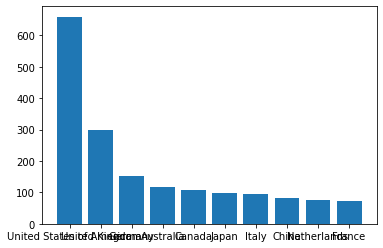

In [45]:
_ = plt.bar(df_times['country'].value_counts().head(10).index, 
            df_times['country'].value_counts().head(10))

* Not satisfied with the looks, so we therefore explicitly create a figure/axis on which we call `bar` (now also adding a color argument)

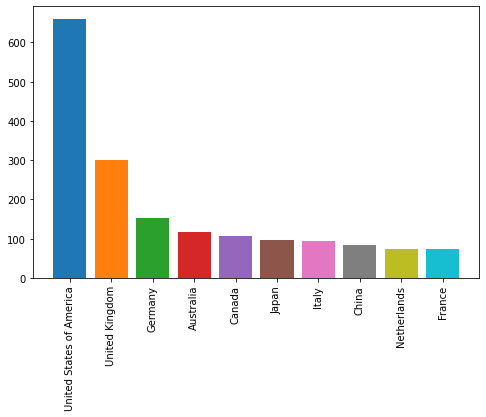

In [46]:
# plt.bar implicitly creates a figure and axes for us, here done explicitly so 
# we can refer to it and make additional customizations of the look
fig = plt.figure()
ax = plt.axes()

ax.bar(df_times['country'].value_counts().head(10).index, 
       df_times['country'].value_counts().head(10),
       color=sns.color_palette())
ax.tick_params(axis='x', rotation=90)
fig.set_size_inches(8, 5)

* Matplotlib is a generic plotting tool, and sometimes it's overly cumbersome to get what you want. 
* Pandas improves on this (a bit), as it tries to infer from the DataFrame/Series object how it should be meaningfully plotted.
  * Typical pattern is index on the x-axis and columns on the y-axis
  * For most matplotlib plotting functions, an **equivalent one** exists on pandas DataFrame or Series or both. These calls return an axis object we can further manipulate using matplotlib functions.
  * Pandas `plot` accepts a combination of matplotlib figure and axis arguments, but often we still need further layout adjustments for a pleasing result.
* In general, you should try to rely on pandas for initial plotting, then customize using matplotlib functions. 
    * This requires you to shape the dataframe you're given to match the type of plotting of interest. An operation you'd have to do anyway, before inputting the data to matplotlib

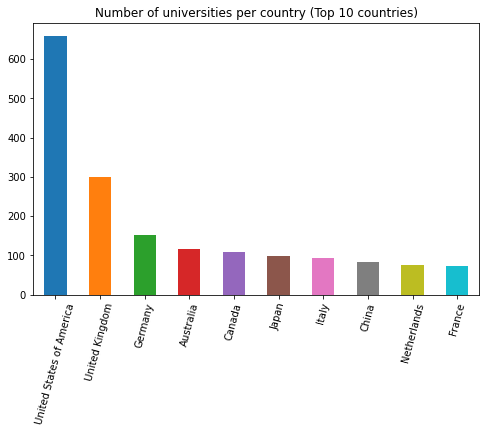

In [47]:
# country is the index of value_counts() dataframe, thus plotted on x-axis
# count value plotted on y-axis
ax_bar = df_times['country'].value_counts().head(10) \
              .plot(kind='bar', color=sns.color_palette(),
                    title='Number of universities per country (Top 10 countries)',
                    figsize=(8, 5))
ax_bar.xaxis.set_tick_params(rotation=75)

### Activating seaborn

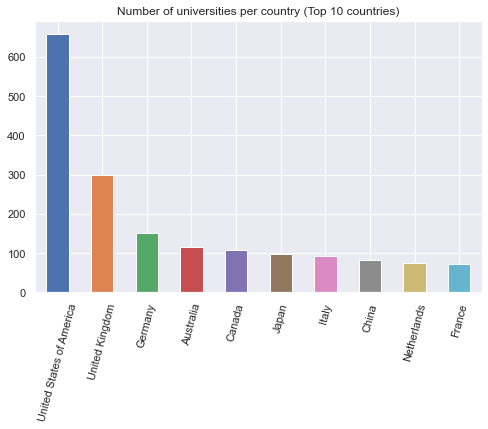

In [48]:
sns.set() # Now activated with seaborn defaults for future plotting
ax_bar = df_times['country'].value_counts().head(10) \
              .plot(kind='bar', color=sns.color_palette(),
                    title='Number of universities per country (Top 10 countries)',
                    figsize=(8, 5))
ax_bar.xaxis.set_tick_params(rotation=75)

### Subplots

In [49]:
df_times_mean_by_year = df_times.groupby('year').mean()
df_times_mean_by_year

teaching   research  citations  student_staff_ratio
year                                                      
2011  54.756500  55.457500  71.589500            15.949485
2012  37.838060  35.884577  57.287065            17.990698
2013  41.683000  40.777500  65.268000            18.413882
2014  37.270000  35.562750  66.536750            18.543990
2015  38.370823  37.202743  68.483791            18.705641
2016  31.584000  28.128625  51.309750            19.116393

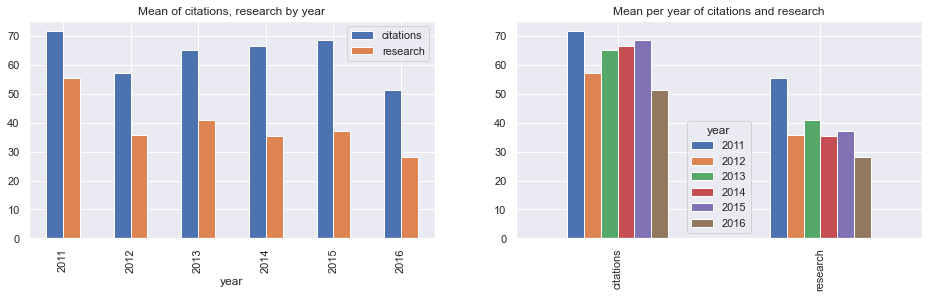

In [50]:
# Defines a 1 row, 2 columns grid which we use by specifying `ax` argument when plotting
fig, axarr = plt.subplots(1, 2, figsize=(16, 4))

# Plots by index, groups are different columns, illustrated by taking transpose in second subplot
df_times_mean_by_year[['citations', 'research']] \
    .plot(kind='bar', color=sns.color_palette(), ax=axarr[0], title='Mean of citations, research by year')

_ = df_times_mean_by_year[['citations', 'research']].T \
    .plot.bar(color=sns.color_palette(), ax=axarr[1], title='Mean per year of citations and research')

## Line charts

* Bar charts work fine for a small number of categories

* When looking at changes over time (or more broadly, a natural ordering of categories), line charts may be more appropriate.

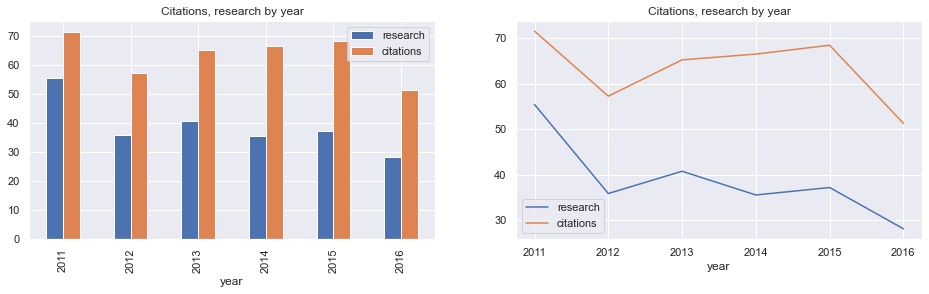

In [51]:
# Defines a 1 row, 2 columns grid which we use by specifying `ax` argument when plotting
fig, axarr = plt.subplots(1, 2, figsize=(16, 4))

# Plots by index, groups are explicitly named
df_times_mean_by_year.plot.bar(y=['research', 'citations'], 
                                color=sns.color_palette(), ax=axarr[0], title='Citations, research by year')

_ = df_times_mean_by_year.plot.line(y=['research', 'citations'],
                                color=sns.color_palette(), ax=axarr[1], title='Citations, research by year')

## Example: Pitfalls of chartings

In [52]:
times_international_students = df_times['international_students']
times_international_students.head()

0    25%
1    27%
2    33%
3    22%
4    27%
Name: international_students, dtype: object

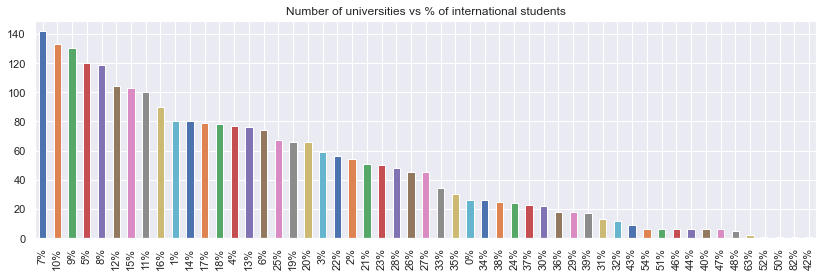

In [53]:
# Bar chart gets cluttered
_ =  times_international_students.value_counts() \
              .plot(kind='bar', color=sns.color_palette(), figsize=(14,4),
                    title='Number of universities vs % of international students')

Don't mislead yourself by using line charts like this

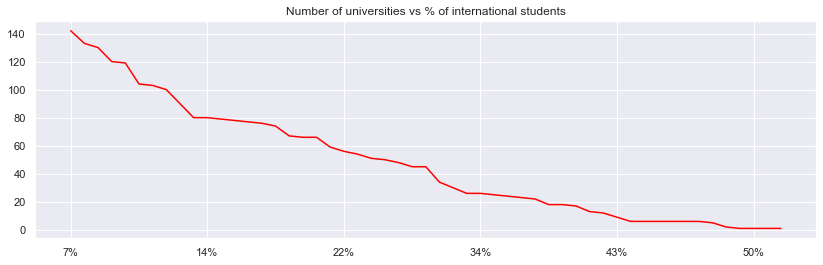

In [54]:
# Line chart could make more sense, but obfuscates that x-axis isn't actually ordered!
_ = times_international_students.value_counts() \
              .plot(kind='line', color='red', figsize=(14, 4),
                    title='Number of universities vs % of international students')

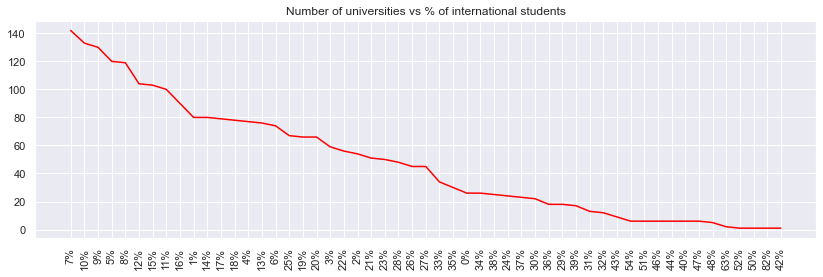

In [55]:
# Now the chart looks less dense without obfuscation, but information isn't really improved
times_international_students.value_counts() \
              .plot(kind='line', color='red', figsize=(14, 4),
                    title='Number of universities vs % of international students')
_ = plt.xticks(np.arange(len(times_international_students.value_counts().index)), 
               times_international_students.value_counts().index, rotation=90)

* Neither bar charts nor line charts really capture this relationship well

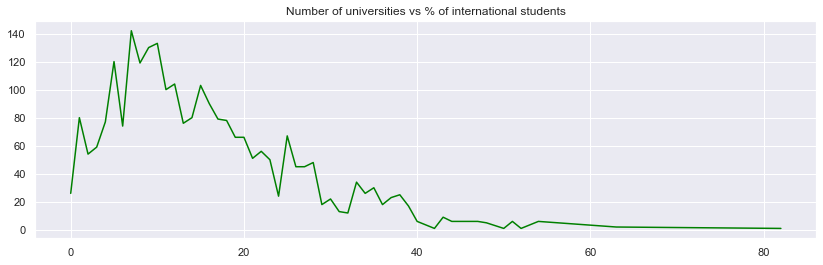

In [56]:
# Creating new column where percentage is float rather than string
df_times['international_students_float'] = times_international_students.str.replace('%', '').astype(float)

# Sorting by index prior to plotting gives us an non-obfuscated x-axis
_ = df_times['international_students_float'].value_counts().sort_index() \
              .plot(kind='line', color='green', figsize=(14, 4),
                    title='Number of universities vs % of international students')


### Histograms

* For illustrating frequency of a variable, histograms may be more appropriate than bar/line charts

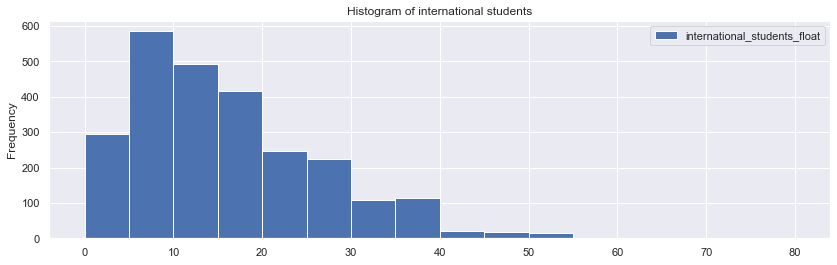

In [57]:
# Works on numerical data for its binning
_ = df_times[['international_students_float']] \
          .plot.hist(bins=16, range=[0, 16*5],
                     title='Histogram of international students', figsize=(14, 4))

## Scatter plots

* Above, we considered aggregated values (e.g. mean) over distinct categories (e.g. year).
* When looking at samples with paired numerical data, scatter plots are used illustrate this relationship.
    * Each sample (university, year) has numerical data for e.g. research and citations.

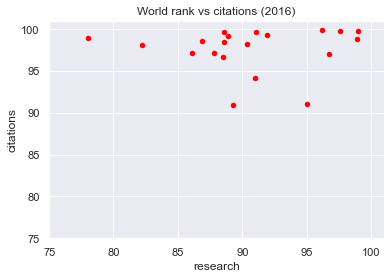

In [58]:
# Observe the x and y axis are different ranges which can be misleading
ax = df_times[df_times.year==2016].head(20) \
           .plot(kind='scatter', x='research', y='citations',
                 color='red', title='World rank vs citations (2016)')

# To correct set the x and y limits explicitly
ax.set_xlim([75, 101])
_ = ax.set_ylim([75, 101])

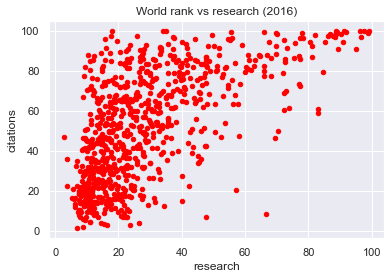

In [59]:
_ = df_times[df_times.year==2016] \
           .plot(kind='scatter', x='research', y='citations',
                 color='red', title='World rank vs research (2016)')

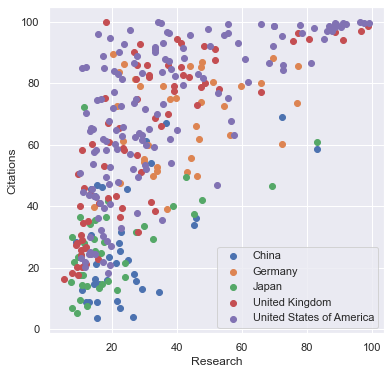

In [60]:
# Scatter plot with coloring by country
fig = plt.figure()
ax = plt.axes()

df_times_by_country = df_times[df_times.year == 2016] \
                        .groupby(['country']) \
                        .filter(lambda g: len(g) > 35)

# Filter produces a subset of original DataFrame, on which we groupby again
for group, df_group in df_times_by_country.groupby(['country']):
    ax.scatter(df_group.research, df_group.citations, label=group)
    
    # Regression lines per group
#     z = np.polyfit(df_group.research, df_group.citations, 1)
#     p = np.poly1d(z)
#     ax.plot(df_group.research, p(df_group.research), label=group)

ax.set_xlabel('Research')
ax.set_ylabel('Citations')
fig.set_size_inches(6, 6)
_ = ax.legend()

This shows you can have a high citation value with low research value, but rarely the other way round.

In [61]:
# The extend to which the variables move in the same direction via correlation
df_times_by_country.research.corr(df_times_by_country.citations)

0.6526219648511961

## Box plots 

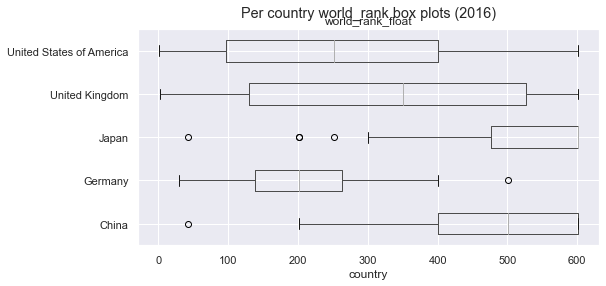

In [62]:
# In effect any world_rank rank (e.g. 601-800) gets the highest possible rank it could have achieved
# Example of data imputation (we could have considered taking the average rather than best rank)
df_times_by_country['world_rank_float'] = \
        pd.to_numeric(df_times_by_country.world_rank.str.split('-').str[0], errors='coerce').dropna()

ax = df_times_by_country.boxplot(
                    by='country', 
                    column=['world_rank_float'], 
                    figsize=(8, 4),
                    vert=False)
_ = plt.gcf().suptitle('Per country world_rank box plots (2016)')

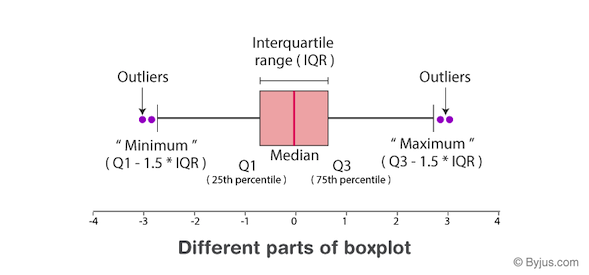

## Date Plotting - data types matter (Self-study)

* Under the hood matplotlib and pandas try to derive sane configurations to display your data
* It can sometimes be necessary to correct data types, so these educated guesses are correct

In [63]:
df_times['year_datetime'] = pd.to_datetime(df_times.year, format="%Y")

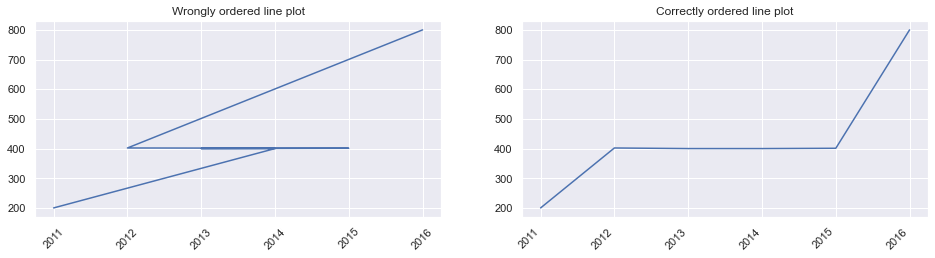

In [64]:
fig, axarr = plt.subplots(1, 2, figsize=(16, 4))

_ = df_times['year'].value_counts().plot.line( 
                              color=sns.color_palette(),
                              title='Wrongly ordered line plot',
                              ax=axarr[0], rot=45)

_ = df_times['year_datetime'].value_counts().plot.line( 
                              color=sns.color_palette(),
                              title='Correctly ordered line plot',
                              ax=axarr[1], rot=45)


## Plotting rules of thumbs

Remember to always include
* Titles and names of axes
* Legend (when applicable)
* Readable ticks (labels on x and y axis)
* Discernable coloring of different variables/categories
* A brief summary of what is plotted, possibly followed by bulleted observations discernable from the plot.

[Rules of thumb for visualization](https://www.beyondtheboxscore.com/2011/1/7/1920544/rules-of-thumb-for-visualization)

* Know Your Story: Consider exactly what you want to convey in your chart.
* Pick an Appropriate Graph Type: Bar or Line charts typically fine options, careful with pie charts.
* Don't Overdo It: Don't try to encapsulate all your data in a single chart, just because it's possible.
* Focus the Message: Keep (and emphasize) only chart elements that tell your story
* Add Color (where appropriate)
* Resist the Urge to Pretty-up the Graph with Chart Junk

Reducing clutter is a non-trivial task, but consider some of these options to alleviate the issue:

* Aggregate data points prior to plotting, or use fewer (sampled) data points.
    * Sometimes your data is simply to massive or multi-facetted to be charted all at once, don't let that ruin the story.
* "Zoom in": View smaller portion of data points (e.g. only 2016)
* Split into multiple plots for different categories (careful, as 10x more plots don't necessarily improve the story)
* Reduce dot size and use alpha (transparency) or hues in scatter plots




# Basics of machine learning with sklearn

* Machine learning is a huge field
* We'll just do a "hello world" of machine learning: a supervised learning (classification) task with `sklearn`


## Iris dataset: classify iris plants into three species

<table>
  <tr><td>
    <img src="https://www.tensorflow.org/images/iris_three_species.jpg"
         alt="Petal geometry compared for three iris species: Iris setosa, Iris virginica, and Iris versicolor">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> Iris setosa, Iris versicolor, and Iris virginica </td></tr>
</table>

* Classic dataset! Can be found on the UCI Machine Learning Repository.

* It includes three iris species with 50 samples each as well as some properties (features) about each flower.

* The species are:
  * Iris setosa
  * Iris virginica
  * Iris versicolor


* The columns in this dataset are:
  * Id
  * SepalLengthCm
  * SepalWidthCm
  * PetalLengthCm
  * PetalWidthCm
  * Species

* The goal is to predict the species (target) based on the sepal and petal measurements (features).

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
new_names = ['sepal_length','sepal_width','petal_length','petal_width','iris_class']
dataset = pd.read_csv(url, names=new_names, skiprows=0, delimiter=',')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   iris_class    150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


Let's have a look at the data.

In [4]:
dataset.head(5)

sepal_length  sepal_width  petal_length  petal_width   iris_class
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

In [5]:
dataset.groupby('iris_class').count()

sepal_length  sepal_width  petal_length  petal_width
iris_class                                                           
Iris-setosa                50           50            50           50
Iris-versicolor            50           50            50           50
Iris-virginica             50           50            50           50

Let's split the data into input features ($x$) and target class ($y$). 

In [6]:
# target labels
y_data = dataset['iris_class']
# input features
x_data = dataset.drop(['iris_class'], axis=1)

print ("dataset : ",dataset.shape)
print ("x : ", x_data.shape)
print ("y : ", y_data.shape)

dataset :  (150, 5)
x :  (150, 4)
y :  (150,)


## Encoding categorical variables

* We'll use predictive models (e.g. neural network) to solve this classification task.
* Models require all input and output variables to be numeric.
* Our targets / labels are categorical at the moment.
* We have to encode our labels into numbers before you can train our model: Each categorical variable is converted to 0, 1 or 2. This indicates a sample has exactly one class.

In [7]:
# Factor encoding of target 
y, uniques = pd.factorize(y_data)
y, uniques

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64),
 Index(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype='object'))

## Train/test split

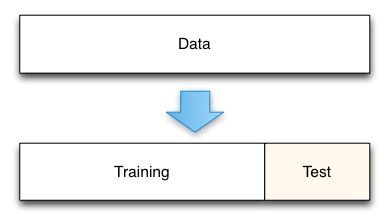

* Below we use a simple train/test split as our form of model validation; i.e. as a test to validate how our neural network model performs.
* Train set: Data which is shown to your model, from which you hope it learns valuable information that generalize to unseen samples.
    * Given large enough models and enough training time, models can learn to perform perfectly on train set.
* Test set: Data used to evaluate your model, which you hope mimics the data your models would see "in the wild".
    * A perfect classifier on the Train set may have overfit the data and not perform well on your test set.
* Roughly speaking, train set performance is "irrelevant" and test set performance (best case) informs us how well the model generalizes
    * Cross-validation is a more elaborate technique for model validation.
    * With larger datasets, a train-valid-test split is often employed.

In [8]:
from sklearn.model_selection import train_test_split

# generate training and test sets
x_train, x_test, y_train, y_test = \
    train_test_split(x_data, y, test_size=0.3, random_state=1)

# converting to float 64bit
x_train = np.array(x_train).astype(np.float64)
x_test  = np.array(x_test).astype(np.float64)
y_train = np.array(y_train).astype(np.float64)
y_test  = np.array(y_test).astype(np.float64)

# data split
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(105, 4) (105,)
(45, 4) (45,)


In [9]:
x_train[:3], y_train[:3]

(array([[7.7, 2.6, 6.9, 2.3],
        [5.7, 3.8, 1.7, 0.3],
        [5. , 3.6, 1.4, 0.2]]),
 array([2., 0., 0.]))

## Define and train model

We'll use `sklearn`'s `MLPClassifier, which implements a multi-layer perceptron (MLP) network that trains using backpropagation.


In [10]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

We'll try out two different models for our purposes here

In [11]:
# model initialisation
lr = LogisticRegression(multi_class='ovr')
mlp = MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=1000, verbose=1)

Let's train the model. In `sklearn`, the `fit function is used to train a machine learning model on the data.

In [12]:
# train our model
lr.fit(x_train, y_train)
mlp.fit(x_train, y_train)

Iteration 1, loss = 1.36637588
Iteration 2, loss = 1.33937263
Iteration 3, loss = 1.31364310
Iteration 4, loss = 1.28922986
Iteration 5, loss = 1.26616725
Iteration 6, loss = 1.24446864
Iteration 7, loss = 1.22415015
Iteration 8, loss = 1.20523244
Iteration 9, loss = 1.18770246
Iteration 10, loss = 1.17155486
Iteration 11, loss = 1.15674142
Iteration 12, loss = 1.14322655
Iteration 13, loss = 1.13096999
Iteration 14, loss = 1.11992058
Iteration 15, loss = 1.11002467
Iteration 16, loss = 1.10122527
Iteration 17, loss = 1.09348937
Iteration 18, loss = 1.08672813
Iteration 19, loss = 1.08084575
Iteration 20, loss = 1.07578125
Iteration 21, loss = 1.07145022
Iteration 22, loss = 1.06779273
Iteration 23, loss = 1.06474886
Iteration 24, loss = 1.06219311
Iteration 25, loss = 1.06005458
Iteration 26, loss = 1.05837172
Iteration 27, loss = 1.05729226
Iteration 28, loss = 1.05681413
Iteration 29, loss = 1.05663792
Iteration 30, loss = 1.05647646
Iteration 31, loss = 1.05627540
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000, verbose=1)

## Model predictions

And look at the predictions.

In [13]:
# use our model to predict
y_pred_lr = lr.predict(x_test)
y_pred = mlp.predict(x_test)

In [14]:
y_pred_lr[:6], y_pred[:6], y_test[:6]

(array([0., 1., 1., 0., 2., 2.]),
 array([0., 1., 1., 0., 2., 1.]),
 array([0., 1., 1., 0., 2., 1.]))

We can also get the predictions out as a per-class probability. To get a single prediction, `predict` selects the entry with highest `proba` value (as `argmax` below). 

In [15]:
mlp.predict_proba(x_test)[:6], mlp.predict_proba(x_test)[:6].argmax(axis=1)

(array([[9.99817769e-01, 1.82115203e-04, 1.15561396e-07],
        [4.74867859e-02, 9.49242065e-01, 3.27114955e-03],
        [4.88974092e-04, 9.95545752e-01, 3.96527400e-03],
        [9.99531110e-01, 4.68486564e-04, 4.03603109e-07],
        [2.19901654e-08, 3.90736962e-02, 9.60926282e-01],
        [8.17464770e-05, 9.21851868e-01, 7.80663853e-02]]),
 array([0, 1, 1, 0, 2, 1], dtype=int64))

In [16]:
# Reset some seaborn layout changes
from matplotlib import rc_file_defaults
rc_file_defaults()

## Model validation

* Accuracy on the test set is one way to evaluate the performance of the model.
    * Remember, we only care about train set performance as we train the model and want to know if the training procedure is converging.
* To evaluate a model, some other commonly used concepts are the confusion matrix, precision and recall scores.
    * All scores can be "read" out from the confusion matrix.
    * The `confusion_matrix` and `classification_report` methods of the `sklearn` metrics library provide these concepts.

Logistic Regression - Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        14
         1.0       0.93      0.72      0.81        18
         2.0       0.71      0.92      0.80        13

    accuracy                           0.87        45
   macro avg       0.88      0.88      0.87        45
weighted avg       0.89      0.87      0.87        45



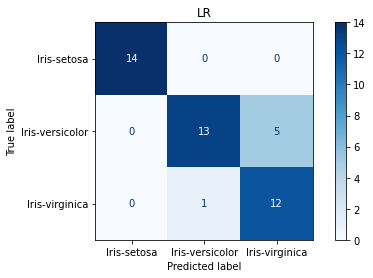

In [20]:
from sklearn.metrics import classification_report, \
        confusion_matrix, plot_confusion_matrix
print("Logistic Regression - Classification report:\n", 
      classification_report(y_test, y_pred_lr))
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plot_confusion_matrix(lr, x_test, y_test, display_labels=uniques, cmap=plt.cm.Blues, ax=ax)
_ = ax.set_title('LR')

* Accuracy is the number of true predictions divided by the number of samples. So for LR:
    * (17+13+10) / (17+13+10+5+1) = 0.87.
* Recall (sensitivity, hit rate) is the number of true predictions of the class, divided by the number of samples of the class. So for LR:
    * Recall for setosa: 1
    * Recall for versicolor: 13 / (13+5) = 0.72
    * Recall for virginica: 12 / (12+1) = 0.92
    * Recall tells us how many of the samples of a class we correctly predict.
    * A classifier always predicting virginica, would have a recall of 1 for virginica.
* Precision is the number of true predictions of the class, divided by the number of total predictions of the class. So for LR:
    * Precision for setosa: 1
    * Precision for versicolor: 13 / (13+1) = 0.93
    * Precision for virginica: 12 / (12+5) = 0.71
    * Precision tells us the fraction of our predictions which are correct.


MLP - Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        14
         1.0       1.00      1.00      1.00        18
         2.0       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



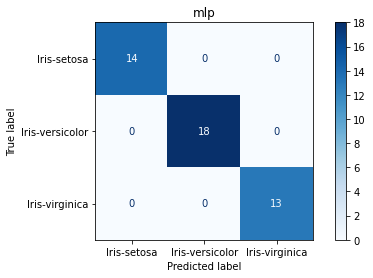

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

print("\nMLP - Classification report:\n", classification_report(y_test, y_pred))
plot_confusion_matrix(mlp, x_test, y_test, display_labels=uniques, cmap=plt.cm.Blues, ax=ax)
_ = ax.set_title('mlp')

# Practical take-away

* For at-a-glance, interactive statistics, use the Pandas profiling library.
    * This mechanized EDA is a starting point for data engineering, e.g. conversion of column types, data imputation/drop missing rows, variable correlations.
* Pandas has easy-to-use, in-built plotting functionality, based on matplotlib. Fine for static visualisation.
    * Shape your data and request pandas plotting. Customize layout in subsequent code.
    * Good plots convey one or a few stories well. Bad plots mislead the reader.
* sklearn can be used for machine learning tasks. It offers many types of models (decision trees, nearest neighbors, neural nets) and is easy to use.
    * Train/test split: So we validate our model on unseen (test) data, as it would receive "in the wild".
    * There are multiple relevant metrics when we validate our model. Accuracy is the crudest, may miss misclassification of certain less prevalent cases.
    * There's much more to machine learning that we can't cover here.

# Interactive data visualisation with Plotly (Self-study)



* Visualisations based off Kaggle notebooks. 

* Dynamic:

  * various operations on the data: zooming, panning, hovering over a data point, etc.
  * great for inspecting data in detail
  * resource-intensive: interactive graphics are much, much more resource-intensive than static ones.


In [22]:
# There's more recent versions of plotly, using this for demonstration 
!pip install plotly==3.10.0

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=4c9b68d2afbfd757678e81bec99ca13255f6d11c02d302eec167f6aea5156b6f
  Stored in directory: c:\users\miaha\appdata\local\pip\cache\wheels\f9\8d\8d\f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [23]:
# for rendering plotly in Colab
# see https://stackoverflow.com/questions/47230817/plotly-notebook-mode-with-google-colaboratory

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [24]:
# plotly
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

## Line Charts


In [66]:
configure_plotly_browser_state() # add this line to see plotly plots in Colab

# prepare data frame
df = df_times.iloc[:100,:]

# import graph objects as "go"
import plotly.graph_objs as go

# Creating trace1
trace1 = go.Scatter(
                    x = df.world_rank,
                    y = df.citations,
                    mode = "lines",
                    name = "citations",
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)'),
                    text= df.university_name)
# Creating trace2
trace2 = go.Scatter(
                    x = df.world_rank,
                    y = df.teaching,
                    mode = "lines+markers",
                    name = "teaching",
                    marker = dict(color = 'rgba(80, 26, 80, 0.8)'),
                    text= df.university_name)
# Creating trace3
trace3 = go.Scatter(
                    x = df.world_rank,
                    y = df.female_male_ratio.apply(lambda r: r.split(':')[0] if not pd.isnull(r) else np.nan),
                    mode = "lines+markers",
                    name = "female_ratio",
                    marker = dict(color = 'rgba(26, 26, 150, 0.8)'),
                    text= df.university_name)
data = [trace1, trace2, trace3]
layout = dict(title = 'Citation and Teaching vs World Rank of Top 100 Universities',
              xaxis= dict(title= 'World Rank',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)
iplot(fig)

## Scatter plots


In [67]:
configure_plotly_browser_state()

# prepare data frames
df2014 = df_times[df_times.year == 2014].iloc[:100,:]
df2015 = df_times[df_times.year == 2015].iloc[:100,:]
df2016 = df_times[df_times.year == 2016].iloc[:100,:]
# import graph objects as "go"
import plotly.graph_objs as go
# creating trace1
trace1 =go.Scatter(
                    x = df2014.world_rank,
                    y = df2014.citations,
                    mode = "markers",
                    name = "2014",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text= df2014.university_name)
# creating trace2
trace2 =go.Scatter(
                    x = df2015.world_rank,
                    y = df2015.citations,
                    mode = "markers",
                    name = "2015",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text= df2015.university_name)
# creating trace3
trace3 =go.Scatter(
                    x = df2016.world_rank,
                    y = df2016.citations,
                    mode = "markers",
                    name = "2016",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text= df2016.university_name)
data = [trace1, trace2, trace3]
layout = dict(title = 'Citation vs world rank of top 100 universities with 2014, 2015 and 2016 years',
              xaxis= dict(title= 'World Rank',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'Citation',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)
iplot(fig)

## Bar charts (example 1)


In [68]:
# prepare data frames
df2014 = df_times[df_times.year == 2014].iloc[:3,:]
df2014

world_rank                     university_name                   country  \
1002          1  California Institute of Technology  United States of America   
1003          2                  Harvard University  United States of America   
1004          2                University of Oxford            United Kingdom   

      teaching international  research  citations income total_score  \
1002      94.4          65.8      98.2       99.8   91.2        94.9   
1003      95.3          66.2      98.5       99.1   40.6        93.9   
1004      89.0          90.2      98.5       95.4   90.3        93.9   

     num_students  student_staff_ratio international_students  \
1002        2,243                  6.9                    27%   
1003       20,152                  8.9                    25%   
1004       19,919                 11.6                    34%   

     female_male_ratio  year  international_students_float year_datetime  
1002           33 : 67  2014                          27.0    2014-01-01  
1003               NaN  2014                          25.0    2014-01-01  
1004           46 : 54  2014                          34.0    2014-01-01

In [69]:
configure_plotly_browser_state()

# prepare data frames
df2014 = df_times[df_times.year == 2014].iloc[:3,:]
# import graph objects as "go"
import plotly.graph_objs as go
# create trace1 
trace1 = go.Bar(
                x = df2014.university_name,
                y = df2014.citations,
                name = "citations",
                marker = dict(color = 'rgba(50, 10, 250, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                text = df2014.country)
# create trace2 
trace2 = go.Bar(
                x = df2014.university_name,
                y = df2014.teaching,
                name = "teaching",
                marker = dict(color = 'rgba(25, 215, 128, 0.5)',
                              line=dict(color='rgb(0,0,0)',width=1.5)),
                text = df2014.country)
data = [trace1, trace2]

layout = {
  'xaxis': {'title': 'Top 3 universities in 2014 (citations and teaching)'},
  'barmode': 'group',
  'title': 'citations and teaching of the top 3 universities in 2014'
};
fig = go.Figure(data = data, layout = layout)
iplot(fig)

## Bar charts (example 2)

* If we change the barmode from *group* to *relative* in the previous example, we get the following. 
* The code bellow illustrates a different syntax for traces.


In [70]:
configure_plotly_browser_state()

# prepare data frames
df2014 = df_times[df_times.year == 2014].iloc[:3,:]
# import graph objects as "go"
import plotly.graph_objs as go

x = df2014.university_name

trace1 = {
  'x': x,
  'y': df2014.citations,
  'name': 'citation',
  'type': 'bar'
}
trace2 = {
  'x': x,
  'y': df2014.teaching,
  'name': 'teaching',
  'type': 'bar'
}
data = [trace1, trace2];
layout = {
  'xaxis': {'title': 'Top 3 universities in 2014 (citations and teaching)'},
  'barmode': 'relative',
  'title': 'citations and teaching of the top 3 universities in 2014'
}
fig = go.Figure(data = data, layout = layout)
iplot(fig)

## Mixing chart types

* We can also see several charts side by side
* Example: Horizontal bar charts next to scatter plots
* Below: citation vs income for universities

In [71]:
configure_plotly_browser_state()

# import graph objects as "go" and import tools
import plotly.graph_objs as go
from plotly import tools
import matplotlib.pyplot as plt
# prepare data frames
df2016 = df_times[df_times.year == 2016].iloc[:7,:]

y_saving = [each for each in df2016.research]
y_net_worth  = [float(each) for each in df2016.income]
x_saving = [each for each in df2016.university_name]
x_net_worth  = [each for each in df2016.university_name]
trace0 = go.Bar(
                x=y_saving,
                y=x_saving,
                marker=dict(color='rgba(171, 50, 96, 0.6)',line=dict(color='rgba(171, 50, 96, 1.0)',width=1)),
                name='research',
                orientation='h',
)
trace1 = go.Scatter(
                x=y_net_worth,
                y=x_net_worth,
                mode='lines+markers',
                line=dict(color='rgb(63, 72, 204)'),
                name='income',
)
layout = dict(
                title='Citations and income of the top 6 universities in 2016',
                yaxis=dict(showticklabels=True,domain=[0, 0.85]),
                yaxis2=dict(showline=True,showticklabels=False,linecolor='rgba(102, 102, 102, 0.8)',linewidth=2,domain=[0, 0.85]),
                xaxis=dict(zeroline=False,showline=False,showticklabels=True,showgrid=True,domain=[0, 0.42]),
                xaxis2=dict(zeroline=False,showline=False,showticklabels=True,showgrid=True,domain=[0.47, 1],side='top',dtick=25),
                legend=dict(x=0.029,y=1.038,font=dict(size=10) ),
                margin=dict(l=200, r=20,t=70,b=70),
                paper_bgcolor='rgb(248, 248, 255)',
                plot_bgcolor='rgb(248, 248, 255)',
)
annotations = []
y_s = np.round(y_saving, decimals=2)
y_nw = np.rint(y_net_worth)
# Adding labels
for ydn, yd, xd in zip(y_nw, y_s, x_saving):
    # labeling the scatter savings
    annotations.append(dict(xref='x2', yref='y2', y=xd, x=ydn - 4,text='{:,}'.format(ydn),font=dict(family='Arial', size=12,color='rgb(63, 72, 204)'),showarrow=False))
    # labeling the bar net worth
    annotations.append(dict(xref='x1', yref='y1', y=xd, x=yd + 3,text=str(yd),font=dict(family='Arial', size=12,color='rgb(171, 50, 96)'),showarrow=False))

layout['annotations'] = annotations

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=True,
                          shared_yaxes=False, vertical_spacing=0.001)

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout'].update(layout)
iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



## Bubble Charts 

* Basic bubble chart: three-dimensional data. 
* Like a scatter plot, where the third dimension is given by bubble size. 
* Can more dimensions using colors, for example.

Example with 4 dimensions:
*  University world rank (first 20 of 2016) vs teaching score
*  number of students (size of bubble)
*  internationalisation score (color)


In [72]:
configure_plotly_browser_state()

# data preparation
df2016 = df_times[df_times.year == 2016].iloc[:20,:]
num_students_size  = [float(each.replace(',', '.')) for each in df2016.num_students]
international_color = [float(each) for each in df2016.international]
data = [
    {
        'y': df2016.teaching,
        'x': df2016.world_rank,
        'mode': 'markers',
        'marker': {
            'color': international_color,
            'size': num_students_size,
            'showscale': True
        },
        "text" :  df2016.university_name
    }
]
iplot(data)

## Box Plots (example of statistical chart)

* A standardized way of displaying the distribution of data.

* The ends of the box represent the lower and upper quartiles, while the median is marked by a line inside the box. 

* Median (50th percentile) = middle value of the data set. 

* 25th percentile = quartile 1 (Q1) that is lower quartile

* 75th percentile = quartile 3 (Q3) that is higher quartile

* height of box = IQR = interquartile range = Q3-Q1

* Outliers =  more than 1.5*IQR away from median commonly.
      

In [73]:
configure_plotly_browser_state()

# data preparation
x2015 = df_times[df_times.year == 2015]

trace0 = go.Box(
    y=x2015.total_score,
    name = 'total score of universities in 2015',
    marker = dict(
        color = 'rgb(12, 12, 140)',
    )
)
trace1 = go.Box(
    y=x2015.research,
    name = 'research of universities in 2015',
    marker = dict(
        color = 'rgb(12, 128, 128)',
    )
)
data = [trace0, trace1]
iplot(data)

## Multiple Subplots

* Useful for comparing more than one features.



In [74]:
configure_plotly_browser_state()

trace1 = go.Scatter(
    x=x2015.world_rank,
    y=x2015.research,
    name = "research"
)
trace2 = go.Scatter(
    x=x2015.world_rank,
    y=x2015.citations,
    xaxis='x2',
    yaxis='y2',
    name = "citations"
)
trace3 = go.Scatter(
    x=x2015.world_rank,
    y=x2015.income,
    xaxis='x3',
    yaxis='y3',
    name = "income"
)
trace4 = go.Scatter(
    x=x2015.world_rank,
    y=x2015.total_score,
    xaxis='x4',
    yaxis='y4',
    name = "total_score"
)
data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    xaxis=dict(
        domain=[0, 0.45]
    ),
    yaxis=dict(
        domain=[0, 0.45]
    ),
    xaxis2=dict(
        domain=[0.55, 1]
    ),
    xaxis3=dict(
        domain=[0, 0.45],
        anchor='y3'
    ),
    xaxis4=dict(
        domain=[0.55, 1],
        anchor='y4'
    ),
    yaxis2=dict(
        domain=[0, 0.45],
        anchor='x2'
    ),
    yaxis3=dict(
        domain=[0.55, 1]
    ),
    yaxis4=dict(
        domain=[0.55, 1],
        anchor='x4'
    ),
    title = 'Research, citation, income and total score vs World Rank of Universities (2015)'
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)